In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as ss

Text(0, 0.5, 'Daily Discharge (cfs)')

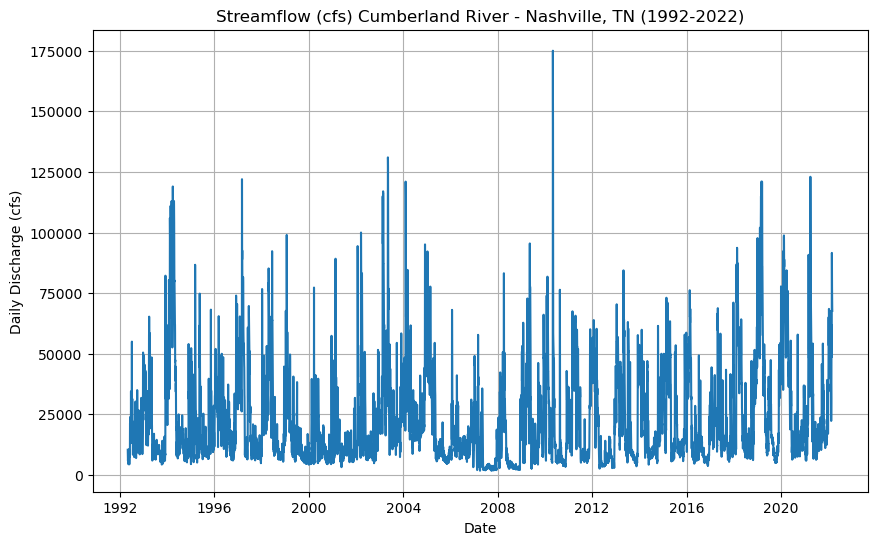

In [2]:
# data preprocessing
data = pd.read_csv('nashville_daily_1992_2022.txt', sep='\t')
data = data.drop(index=0)
data = data.drop(columns=['agency_cd', 'site_no', '129904_00060_00003_cd'])
data = data.rename({'129904_00060_00003':'Flow', 'datetime':'Date'}, axis=1)
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data['Year'] = data['Date'].dt.year
data['Flow'] = np.where(data['Flow']=='Ice', np.nan, data['Flow'])
data = data.fillna(method='ffill')
data['Flow'] = data['Flow'].astype(float)

# daily disccharge time series plot
plt.figure(figsize = (10,6))
plt.title('Streamflow (cfs) Cumberland River - Nashville, TN (1992-2022)')
plt.grid()
plt.plot(data['Date'], data["Flow"])
plt.xlabel('Date')
plt.ylabel('Daily Discharge (cfs)')

In [3]:
def moments(data):
  mean = data.mean()
  std_dev = data.std()
  skew = data.skew()
  return mean, std_dev, skew

In [4]:
# annual maximum dataframe
maxQ = data.groupby(['Year']).max()
maxQ

,Date,Flow
Year,,
1992,1992-12-31,55000.0
1993,1993-12-31,82200.0
1994,1994-12-31,119000.0
1995,1995-12-31,86700.0
1996,1996-12-31,74000.0
1997,1997-12-31,122000.0
1998,1998-12-31,92300.0
1999,1999-12-31,99000.0
2000,2000-12-31,77300.0


Text(0.5, 1.0, ' Annual Maximum Flow (cfs) ')

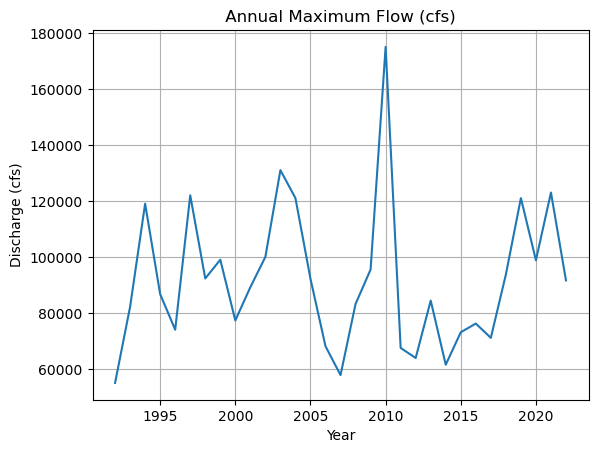

In [5]:
plt.plot(maxQ.index, maxQ['Flow'])
plt.xlabel('Year')
plt.ylabel('Discharge (cfs)')
plt.grid()
plt.title('Annual maximum flow (cfs) Cumberland River - Nashvilla, TN (1992-2022)')
plt.title(' Annual Maximum Flow (cfs) ')

In [6]:
def lognormal_params(data, method='MLE'):
  if method=='MOM':
    log_data = np.log(data)
    mu, sigma, skew = moments(log_data)
    shape = sigma
    scale = np.exp(mu)
    loc = 0
    
  elif method=='MLE':
    shape, loc, scale = ss.lognorm.fit(data, floc=0)

  
  return shape, loc, scale

def lognormal_pdf(data, method='MLE'):
  shape, loc, scale = lognormal_params(data, method)
  x = np.arange(175000)
  pdf = ss.lognorm.pdf(x, shape, loc, scale)
  plt.hist(data, density=True, color='grey')
  plt.plot(x, pdf, 'k')
  plt.title(method + ' Fitted Lognormal PDF')
  plt.xlabel('Streamflow (cfs)')
  plt.ylabel('Probability Density')
  plt.text(110000, 2e-5, f'Shape : {shape:.3f}, \nScale : {scale:.3f}', fontsize=12)
  


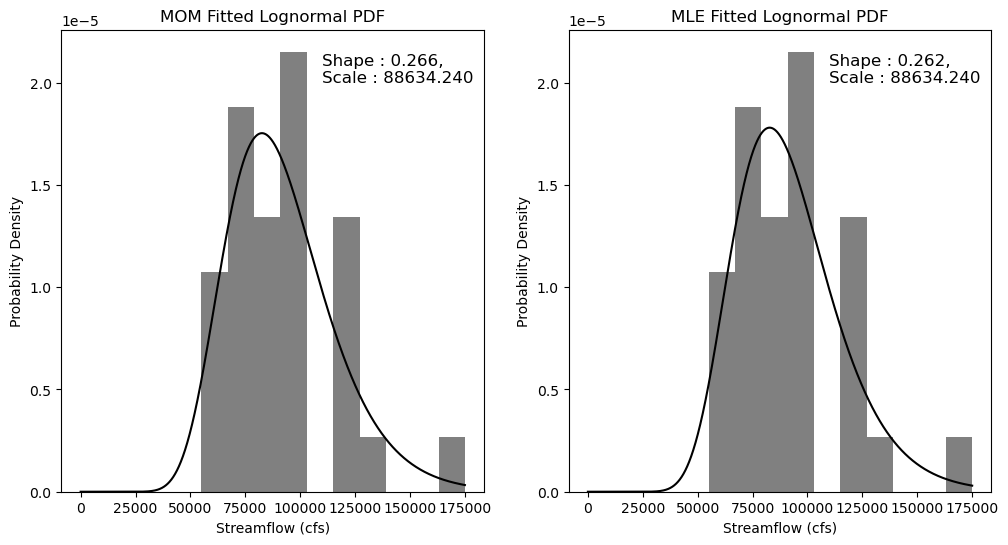

In [7]:
# PLotting histogram with fitted Lognormal PDF

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
lognormal_pdf(maxQ['Flow'], 'MOM')

plt.subplot(1,2,2)
lognormal_pdf(maxQ['Flow'], 'MLE')

In [8]:
# Empirical CDF 
def ecdf(data):
  data = np.sort(data)
  n = len(data)
  ecdf = np.arange(1, n+1)/(n+1)
  return ecdf

# Lognormal QQ Plot Function
def LognormQQ(data, method):
  shape, loc, scale = lognormal_params(data, method)
  x_observed = np.sort(data)
  n = len(data)
  ecdf = np.arange(1, n+1)/(n+1)
  x_fitted = ss.lognorm.ppf(ecdf, shape, loc, scale)
  rho = np.corrcoef(x_observed, x_fitted)[0,1]
  plt.scatter(x_observed, x_fitted, color='red')
  plt.plot(x_observed, x_observed, 'k')
  plt.xlabel('Observations')
  plt.ylabel('Fitted Values')
  plt.title(method + ' Lognormal QQ Plot')

  #Estimate p-value of correlation coefficient
  rhoVector = np.zeros(10000)
  for i in range(10000):
    x = ss.lognorm.rvs(shape, loc, scale, len(data))
    rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0,1]
  
  count=0
  for i in range(len(rhoVector)):
    if rho < rhoVector[i]:
      count+=1
  p_value = 1 - count/10000

  plt.text(60000, 160000, f'Rho = {rho:.3f} \nP-Value = {p_value:.3f}', fontsize=12)
  return rho,p_value 

(0.976500265449459, 0.24670000000000003)

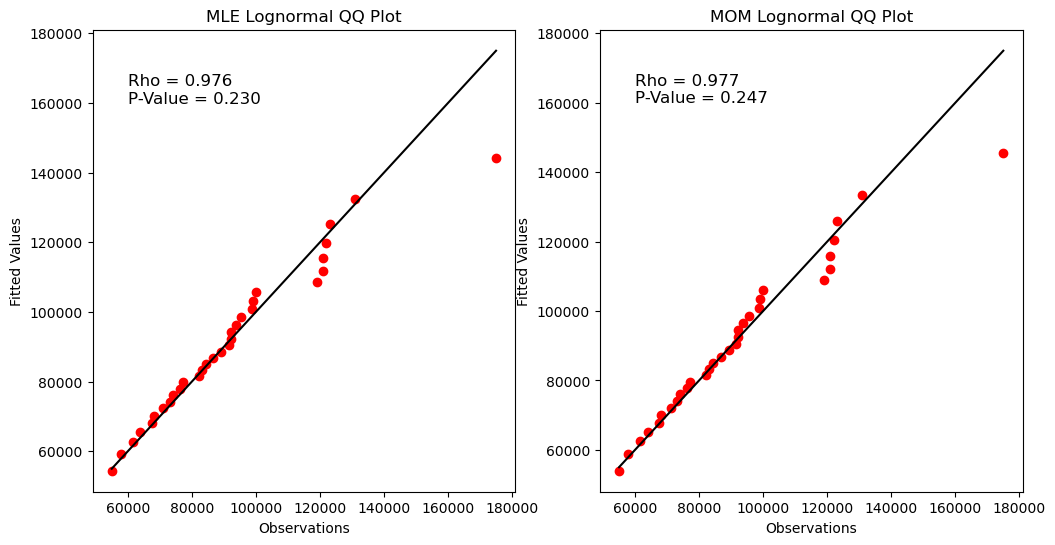

In [9]:
# Plotting QQ Plots for MOM and MLE Lognormal 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
LognormQQ(maxQ['Flow'], 'MLE')

plt.subplot(1,2,2)
LognormQQ(maxQ['Flow'], 'MOM')

In [10]:
def gumbel_params(data, method='MLE'):
  if method=='MOM':
    mu, sigma, skew = moments(data)
    scale = np.sqrt(6*(sigma**2)/(3.1415)**2)
    loc = mu - 0.5772*scale
    
  elif method=='MLE':
    loc, scale = ss.gumbel_r.fit(data)
  
  return loc, scale

def gumbel_pdf(data, method='MLE'):
  loc, scale = gumbel_params(data, method)
  x = np.arange(175000)
  pdf = ss.gumbel_r.pdf(x, loc, scale)
  plt.hist(data, density=True, color='grey')
  plt.plot(x, pdf, 'k')
  plt.title(method + ' Fitted Gumbel PDF')
  plt.xlabel('Streamflow (cfs)')
  plt.ylabel('Probability Density')
  plt.text(0, 2e-5, f'Loc: {loc:.3f}, \nScale : {scale:.3f}', fontsize=12)

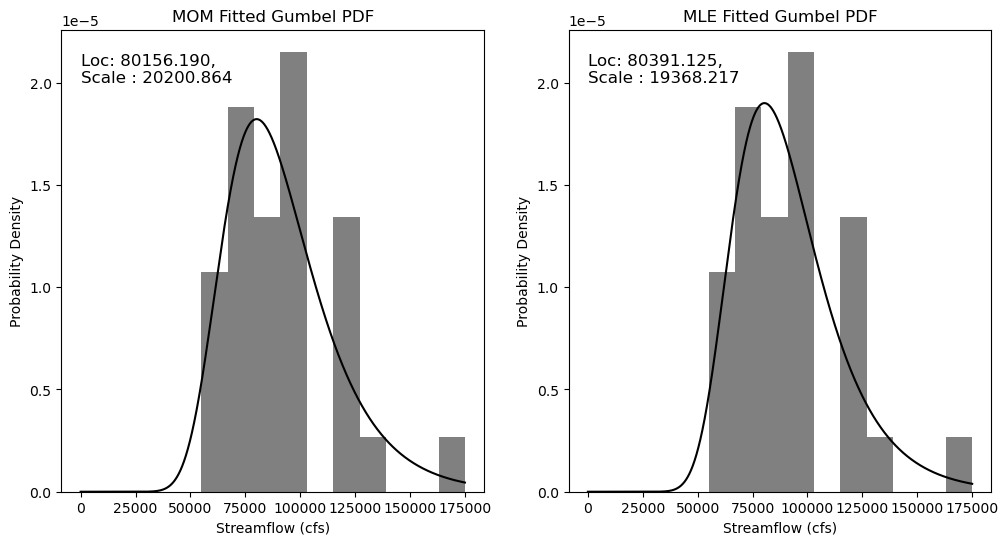

In [11]:
# PLotting histogram with fitted Lognormal PDF

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
gumbel_pdf(maxQ['Flow'], 'MOM')

plt.subplot(1,2,2)
gumbel_pdf(maxQ['Flow'], 'MLE')

In [12]:
# Gumbel QQ Plot function
def GumbelQQ(data, method='MLE'):
  x_observed = np.sort(data)
  n = len(data)
  ecdf = np.arange(1, n+1)/(n+1)
  loc, scale = gumbel_params(data, method)
  x_fitted = ss.gumbel_r.ppf(ecdf, loc, scale)
  rho = np.corrcoef(x_observed, x_fitted)[0,1]
  plt.scatter(x_observed, x_fitted, color='red')
  plt.plot(x_observed, x_observed, 'k')
  plt.xlabel('Observations')
  plt.ylabel('Fitted Values')
  plt.title(method + ' Gumbel QQ Plot')

  #Estimate p-value of correlation coefficient
  rhoVector = np.zeros(10000)
  for i in range(10000):
    x = ss.gumbel_r.rvs(loc, scale, len(data))
    rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0,1]
  
  count=0
  for i in range(len(rhoVector)):
    if rho < rhoVector[i]:
      count+=1
  p_value = 1 - count/10000
  plt.text(60000, 160000, f'Rho = {rho:.5f} \nP-Value = {p_value:.3f}', fontsize=12)


Text(0.5, 0.98, 'MOM and MLE-fitted Gumbel distribution QQ plots')

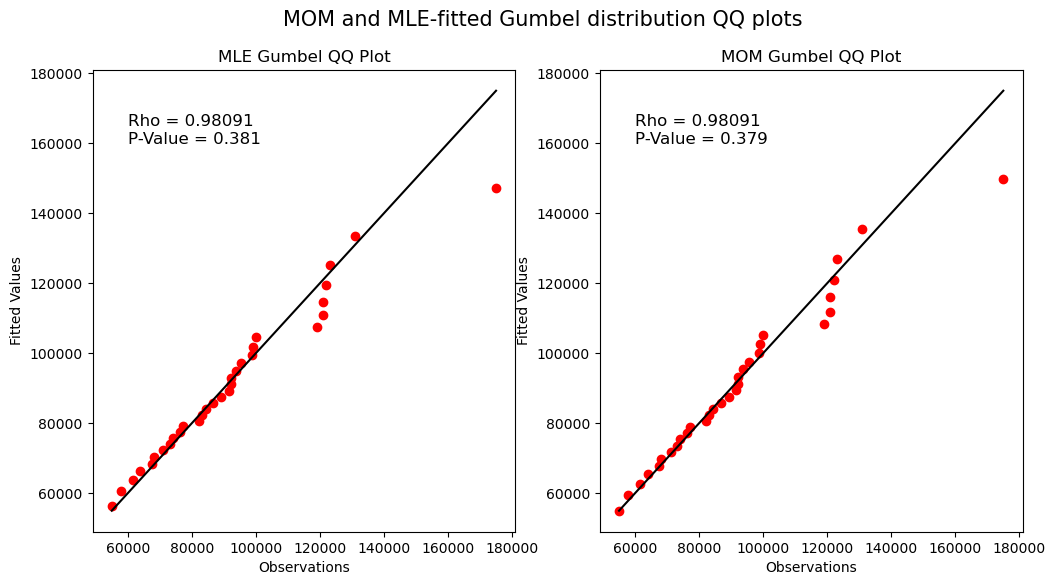

In [13]:
# Plotting QQ Plots for MOM and MLE Gumbel 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
GumbelQQ(maxQ['Flow'], 'MLE')

plt.subplot(1,2,2)
GumbelQQ(maxQ['Flow'], 'MOM')
plt.suptitle('MOM and MLE-fitted Gumbel distribution QQ plots', fontsize=15)

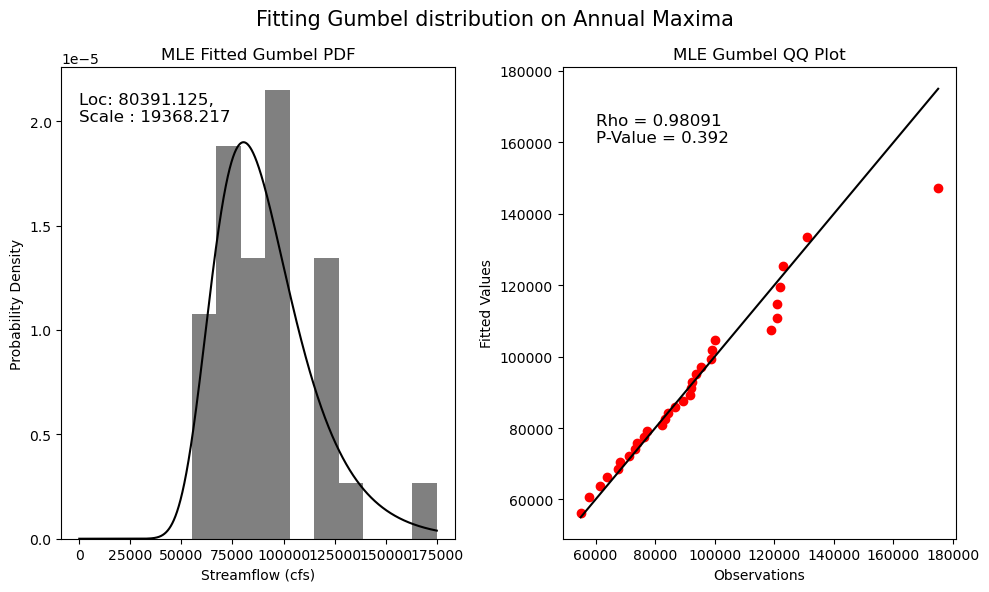

In [23]:
plt.figure(figsize= (10,6))
plt.subplot(1,2,1)
gumbel_pdf(maxQ['Flow'], 'MLE')

plt.subplot(1,2,2)
GumbelQQ(maxQ['Flow'], 'MLE')
plt.suptitle('Fitting Gumbel distribution on Annual Maxima', fontsize=15)
plt.tight_layout()

plt.savefig('gumbel.png', transparent = True)

The MLE-fitted Gumbel distribution has the best fit to annual maximum flows. It has a better rho than Lognormal fits and has a larger p-value than MOM-fitted Gumbel. Therefore, MLE-fitted Gumbel distribution will be used to estimate extreme streamflows (100-yr and 500-yr)

In [15]:
# 100-yr flood
loc, scale = gumbel_params(maxQ['Flow'], 'MLE')
hun_yr_flood = ss.gumbel_r.ppf(0.99, loc, scale)
hun_yr_flood
f'The hundred year flood on the Cumberland River at Nashville, TN has a streamflow of {hun_yr_flood:.2f} cfs'

'The hundred year flood on the Cumberland River at Nashville, TN has a streamflow of 169487.81 cfs'

In [16]:
# Defining a function for analytical CI
def ci_xp(xp,scale,p,n,alpha):
  y=-np.log(-np.log(p))
  var_xp = ((scale**2)*(1.11+0.52*y+0.61*y*y))/n
  z_score = ss.norm.ppf((1-alpha/2),0,1)
  low = xp - z_score*np.sqrt(var_xp)
  high = xp + z_score*np.sqrt(var_xp)
  return (low,high)

# 95% CI for 100-yr flood
ci100 = ci_xp(hun_yr_flood,scale,0.99,len(maxQ),0.05)

f'The 95% confidence interval for a 100-yr flood on the Cumberland River at Nashville, TN is {ci100}'

'The 95% confidence interval for a 100-yr flood on the Cumberland River at Nashville, TN is (141868.17464713875, 197107.4522789459)'

In [17]:
two_hun_yr_flood = ss.gumbel_r.ppf(0.995, loc, scale)

# 95% CI for 200-yr flood
ci200 = ci_xp(two_hun_yr_flood,scale,0.995,len(maxQ),0.05)
f'The 200-yr flood on the Cumberland River at Nashville, TN has a streamflow of {two_hun_yr_flood:.2f} cfs'

'The 200-yr flood on the Cumberland River at Nashville, TN has a streamflow of 182961.56 cfs'

In [18]:
five_hun_yr_flood = ss.gumbel_r.ppf(0.998, loc, scale)

f'The 500-yr flood on the Cumberland River at Nashville, TN has a streamflow of {five_hun_yr_flood:.2f} cfs'

'The 500-yr flood on the Cumberland River at Nashville, TN has a streamflow of 200737.62 cfs'

In [19]:
# 95% CI for 100-yr flood
ci500 = ci_xp(five_hun_yr_flood,scale,0.998,len(maxQ),0.05)

f'The 95% confidence interval for a 100-yr flood on the Cumberland River at Nashville, TN is ({ci500[0]:.2f}, {ci500[1]:.2f})'

'The 95% confidence interval for a 100-yr flood on the Cumberland River at Nashville, TN is (164729.48, 236745.76)'

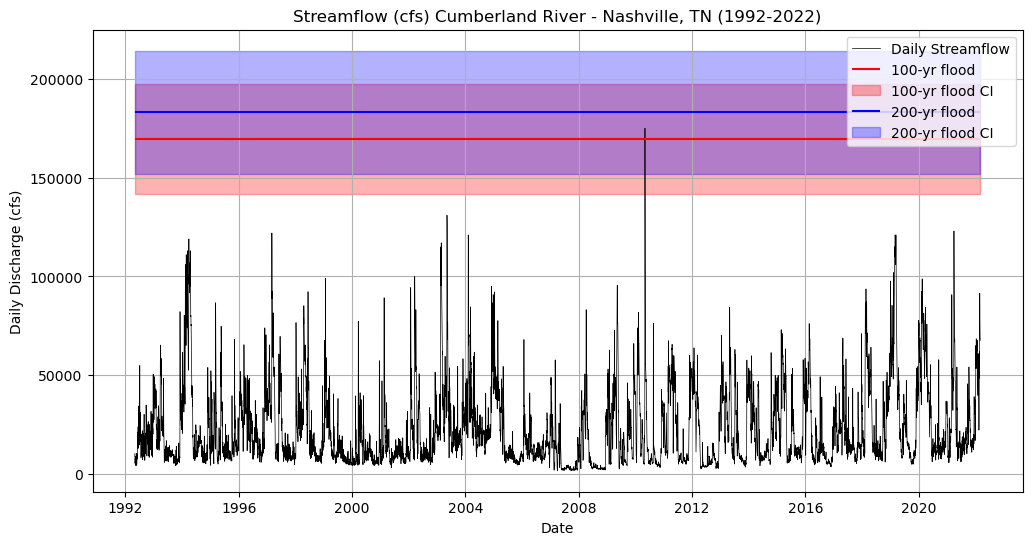

In [20]:
# daily disccharge time series plot 
plt.figure(figsize=(12,6))
plt.title('Streamflow (cfs) Cumberland River - Nashville, TN (1992-2022)')
plt.grid()
plt.plot(data['Date'], data["Flow"], linewidth = 0.5, color = 'black', label = 'Daily Streamflow')
plt.xlabel('Date')
plt.ylabel('Daily Discharge (cfs)')
plt.hlines(hun_yr_flood, data['Date'].iloc[0], data['Date'].iloc[-1], color='red', label = '100-yr flood')
plt.fill_between([data['Date'].iloc[0], data['Date'].iloc[-1]], (ci100[0]), (ci100[1]), color='r', alpha=.3, label='100-yr flood CI')
plt.hlines(two_hun_yr_flood, data['Date'].iloc[0], data['Date'].iloc[-1], color='blue', label = '200-yr flood')
plt.fill_between([data['Date'].iloc[0], data['Date'].iloc[-1]], (ci200[0]), (ci200[1]), color='b', alpha=.3, label='200-yr flood CI')
plt.legend()

In [21]:
%store hun_yr_flood
%store two_hun_yr_flood
%store five_hun_yr_flood
%store ci100
%store ci500
%store ci200

Stored 'hun_yr_flood' (float64)
Stored 'two_hun_yr_flood' (float64)
Stored 'five_hun_yr_flood' (float64)
Stored 'ci100' (tuple)
Stored 'ci500' (tuple)
Stored 'ci200' (tuple)


Text(0, 0.5, 'Daily Discharge (cfs)')

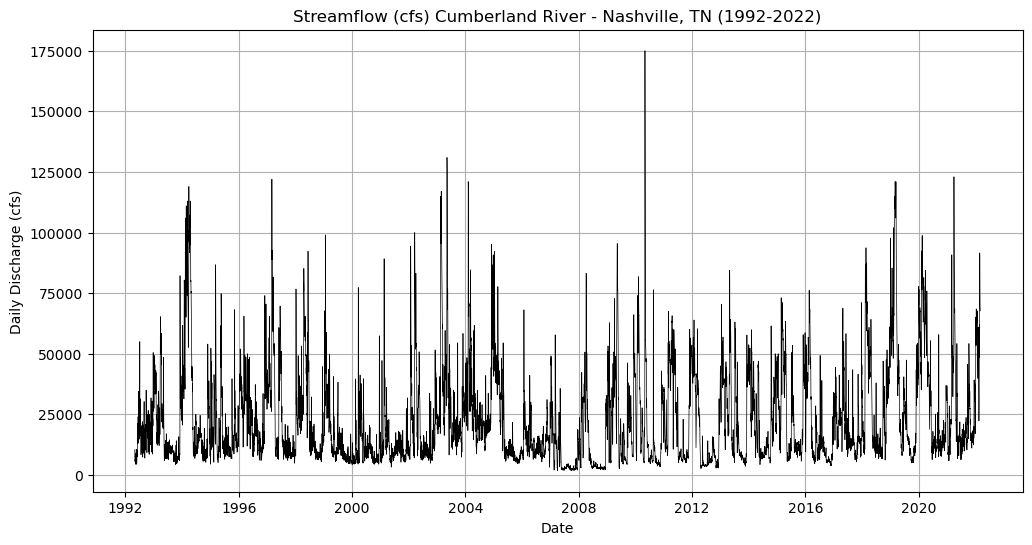

In [22]:
# daily disccharge time series plot 
plt.figure(figsize=(12,6))
plt.title('Streamflow (cfs) Cumberland River - Nashville, TN (1992-2022)')
plt.grid()
plt.plot(data['Date'], data["Flow"], linewidth = 0.5, color = 'black', label = 'Daily Streamflow')
plt.xlabel('Date')
plt.ylabel('Daily Discharge (cfs)')